In [ ]:
import os
import time
import datetime
from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/CS505_final_drive/data/df_class1.csv")
#"/Users/canerozer/Desktop/BU/FALL2023/CS505/Final_Project/data/df_class1.csv"
#'/content/drive/MyDrive/CS505_final_drive/data/df_experiment.csv'


In [ ]:
df.head()

,Id,Text
0,9771,Technical problem with this DVD Like the Dinos...
1,1205441,move on I fast forward through chunks of this ...
2,922828,"If you read the Koontz book, you will absolute..."
3,878469,"WTF WTF, Amazon, this is NOT the full movie, i..."
4,910248,"I really tried, but this is just awful. Colin ..."


In [ ]:
docs= df["Text"].to_list()

docs[:10]

["Technical problem with this DVD Like the Dinosaur Collector's Edition DVD, this one won't play on my Pioneer Elite DV- player. It runs for about  minutes and then just stops.",
 'move on I fast forward through chunks of this movie too many stupid things happen including him saying never get involved with others, but then he goes way out of his way to get involved with others not like it happened naturally and then the ending lame.',
 'If you read the Koontz book, you will absolutely hate this movie Yes, the character names are the same and the plot line is similar enough to drive you mad, but the acting and everything else is atrocious. The Deucalion characterization makes no sense at all. Save your money and flee just like Koontz did. Or better yet, read the book which is brilliant.',
 "WTF WTF, Amazon, this is NOT the full movie, it's the five minute intro to the movie! I want my money back and I want to see this MOVIE, looks great!",
 "I really tried, but this is just awful. Colin

<ipython-input-6-0dc1d487ac7d>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(doc_lengths)


<Axes: ylabel='Density'>

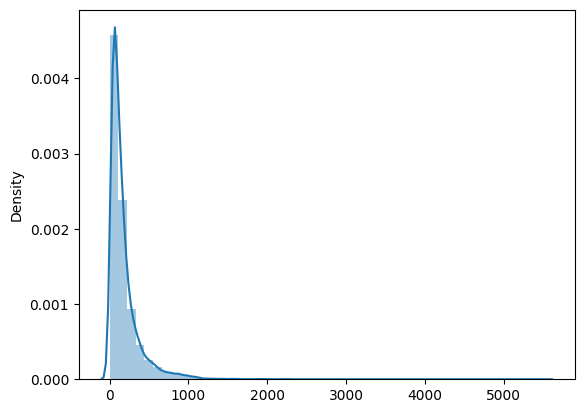

In [ ]:
doc_lengths = []

for doc in docs:

    # get rough token count distribution
    tokens = nltk.word_tokenize(doc)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)

In [ ]:
np.average(doc_lengths)

178.63125

In [ ]:
# the max token length
len(doc_lengths[doc_lengths > 768])/len(doc_lengths)

0.025543478260869567

In [ ]:
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium



vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [ ]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))



The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


In [ ]:
batch_size=2

In [ ]:
class GPT2Dataset(Dataset):

    def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

        self.tokenizer = tokenizer
        self.input_ids = []
        self.attn_masks = []

        for txt in txt_list:

            encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

            self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
            self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attn_masks[idx]


In [ ]:
dataset = GPT2Dataset(docs, tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

6,624 training samples
  736 validation samples


In [ ]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
# some parameters I cooked up that work reasonably well

epochs = 4 #YOU MAY LOWER THIS
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = warmup_steps,
                                            num_training_steps = total_steps)

In [ ]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [ ]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()

        outputs = model(  b_input_ids,
                          labels=b_labels,
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,
                                    top_k=50,
                                    max_length = 200,
                                    top_p=0.95,
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        with torch.no_grad():

            outputs  = model(b_input_ids,
#                            token_type_ids=None,
                             attention_mask = b_masks,
                            labels=b_labels)

            loss = outputs[0]

        batch_loss = loss.item()
        total_eval_loss += batch_loss

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  3,312. Loss: 0.4510518014431.   Elapsed: 0:00:50.
0:  bipartisan, the U.S. Department of Education and the U Institute have a lot of money to spend on waste, fraud, fraud, and waste. However, the only way to stop this waste is to stop the most disturbing waste on the face of the planet


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  3,312. Loss: 1.1098854541778564.   Elapsed: 0:01:44.
0:  increasingThis film deals with a story, with no one being held hostage by a man who is very powerful and often is able to play a bad guy. It was based on a short story by Kari Bell, who played a powerful man, but is a very strong antagonist who is extremely powerful and sometimes a violent bad guy. The film has an intriguing cast and there are some good characters who are talented, but not very good. The plot is pretty weak and bad at times as well. The film tries to make a bad move, rather than trying to get along with everyone in the film.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  3,312. Loss: 4.000404357910156.   Elapsed: 0:02:37.
0: dayRomeo. Rana This film has a decent score, but I would have liked a more mature aspect ratio. I hate old stuff. This was supposed to be a comedy movie, but there was a point in that and it was a failure. I didn't like the overall theme and plot of it, but it did work as a comedy. Unfortunately, I couldn't enjoy the entire show because I had to watch a bunch of bad jokes and the comedy wasn't enjoyable. What was enjoyable, even if I wanted something a little more serious, was the jokes about what happened with the girls, and the girls don't seem to notice this film. It was supposed to be more of a humorous attempt at humor. It did the job, but there were too many bad laughs and the ending never seemed to be anywhere near that funny. The show itself was more about humor than anything else, and the story was a total waste of time.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  3,312. Loss: 0.5005162358283997.   Elapsed: 0:03:31.
0:  HangDHS


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  3,312. Loss: 1.1047015190124512.   Elapsed: 0:04:21.
0:  foodsIn general, I found these movies to be entertaining enough and entertaining enough to keep me up at night. Not so if they're trying to be exciting or the most entertaining thing a viewer can do for a living.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  3,312. Loss: 1.4535101652145386.   Elapsed: 0:05:13.
0:  trailIt's been a long time since I saw these kinds of movies in theaters. What a movie, bad movies, bad acting!The good ones were more like scary movies with a horrible plot and a bad cast. However I kept watching them and I had little interest to see how this one would fare. The worst ones were about a zombie who doesn't understand the plot and thinks he has something to do with the zombies. Now this movie has a lot of horror with good acting and bad acting.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  3,312. Loss: 0.6925815939903259.   Elapsed: 0:06:05.
0: intendThis should be a big pile of crap. You could take a bunch of movies and make a pretty good movie about it. I would not recommend to anybody.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  3,312. Loss: 2.682276487350464.   Elapsed: 0:06:56.
0:  surroundIf I could just pull it out, I would. But it's so hard to do, and I'm sure the first one I'd take was for the first time! So, why are you asking me such questions in the first place? I'd rather spend a day or two with friends than this. There are so many questions I can't answer, or so much of them that it goes nowhere in this mess! What I mean by that is this, I don't know who he is for! The only thing I will say about him, is he's so good that he's one of the worst actors I've seen, I've never seen him in a movie that is so lowbudget! I'm pretty sure I'd have never seen him out there in one of those, except for the first one. So, I'd just give the show a thumbs up!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  3,312. Loss: 0.4070892035961151.   Elapsed: 0:07:48.
0:  reflexTerrible script, too much gun violence, bad character development, no storyline. A movie by the same name should have been entertaining.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  3,312. Loss: 0.6981761455535889.   Elapsed: 0:08:39.
0:  displayThe original  season of the TV show  are out now. I will have to start to type in these spoilers a bit.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  3,312. Loss: 1.9187411069869995.   Elapsed: 0:09:31.
0:  pastorWhat a waste of my money. This is a poor attempt of an action movie with a good actor but it doesnt even play the role that was originally supposed to be that. It is dumb but as a matter of fact I am the only one who is interested in the story. I can tell you what is going on in the story. The movie will be interesting and have good story telling but the acting is just stupid and bad. I will say that it is funny but I can't watch the video because I am a comedy fan.This is about all of it because I am bored and the plot is stupid. I will be returning to my review here but the reviews are mostly the stupid ones.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  3,312. Loss: 2.035567045211792.   Elapsed: 0:10:23.
0:  illicitTwo years,  minutes,  minutes,  minutes of music,  minutes,  minutes of the TV show. This movie is a rip-off. The camera is too slow, I don't feel the camera is moving. I could only watch  minutes of this movie I was already over the cliff and it was getting so tedious that it was just me walking around. I am a musical, a writer, a man. What was good about this movie was it was so well made, well written, well recorded, and acted with beautiful actors that it's hard to watch. But, it really wasn't even worth the money it got because of these other bad actors and the fact that if you're like me you could enjoy this movie and have some fun.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  3,312. Loss: 0.7476939558982849.   Elapsed: 0:11:16.
0:  LiberationThe worst movie I've ever seen. The movie is actually worse than this one. The acting is worse than the movie itself. I was not expecting this. The characters are better than the rest, and I felt like there wasn't enough real content. I was bored to tears.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  3,312. Loss: 1.0456410646438599.   Elapsed: 0:12:07.
0:  NamI felt the need for this movie. The acting was okay. We see some of the world's most famous celebrities get the ball and run around and shoot.The plot is lame. And with some bad acting we are supposed to follow the plot but these actors weren't even at the end of the movie.This movie has no story and only takes place around the movie. The worst part was that we just left our characters there. I will be surprised if they were all dead but the film made no sense.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  3,312. Loss: 0.1261553168296814.   Elapsed: 0:12:59.
0: IONA good movie, but not really worth this price, as this was the one that was not really worth the wait. I mean, I'm kind of a weird nerd that has read this many times. And I figured it could be good if they figured out what the heck they were doing with this series. The acting was just as bad as most people in this story because I was so sure the movie would be great. The camera angles looked cool in the movie, but in the film, the characters were so low, and so the scene was so lame it had to have been filmed on a standard standard DVD that had  cameras, and this set was cut to look more like a normal print! This was  minutes long, and was way long after it started, the movie was like one hour long. Really, you can't be too much of a spoiler about the story. And what if a kid gets sick of the lame script, and after  minutes you are just bored that


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  3,312. Loss: 0.6711881160736084.   Elapsed: 0:13:52.
0:  glimpseJust plain bad!I got this movie a year ago and was excited because I was able to sit through the first thirty minutes and see the first  minutes of the movie.It was slow and boring. I was a big Star Trek fan but my expectations were minimal. I wanted to see more of the originals and not just the one. It's like the people from the early  on in it that they actually ran the show to the theater with lots of them trying to watch it. So even if they were not at the theaters, I would have stopped. I still remember the first time I saw it. It was good but the movie was poorly executed and the actors didn't make good movies.The whole thing sucked.The script is just plain bad.I felt ripped off at first, but when I went to watch it again I was happy. I was excited for the next half hour. I felt like I'd finally found the way to watch the show.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  3,312. Loss: 2.544663190841675.   Elapsed: 0:14:45.
0:  LaureThe Most Stupid Movie of Time I've ever seen, Not in Hollywood. But I can see why Hollywood had the audacity to use the term 'horror' and why the film was the most depressing ever directed by a talented writer. I mean to look at some Hollywood movies like Woody Allen's Dracula of the Dead, The Last Time To Kill, and a film I like but the film, itself is not scary at all, even the fact of its existence, is the only major issue. Why? There are so many movies about the killer, most of which were made in  that were scary and only the worst, not the most stupid.I'm not joking. I know Hollywood has a reputation of wasting time on anything but bad movies. There are movies like The Village, when it's supposed to be a good movie, it's a bad one, as well as the movies made by people who could't act or act and could easily act. So to say it's one


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  3,312. Loss: 1.109604001045227.   Elapsed: 0:15:38.
0: ismThis is one of the worst movies I have ever seen. This is a good movie, not a scary movie I've ever seen, but it is only scary I can't do anything to make myself uncomfortable. This movie is just plain stupid. Don't buy.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  3,312. Loss: 0.5837228298187256.   Elapsed: 0:16:29.
0: ounNot even in the movies at all.The originality of the movie could not be put into it this was the sequel, it was more like the first movie. It looked more like the first one than the second one. So one might actually want to see that instead of watching it.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  3,312. Loss: 1.1014591455459595.   Elapsed: 0:17:21.
0:  electionThis mess is so bad I have to say that I actually agree with the description for this horrible movie. It is actually a real joke. What a waste. I am shocked by the lack of any good actors at this movie's lowest point. I thought I had heard bad things about it, just couldn't believe what I saw. I didn't watch any of the other versions, it was a horrible mess. The writing and direction is horrible. It's like watching some of the original comic books in a cardboard box.The characters do not have the charisma, sophistication, and personality the actors were given. I found this whole movie a waste of time, and a waste of money.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  3,312. Loss: 0.47905611991882324.   Elapsed: 0:18:13.
0:  crazyA very disappointing film. It is not one of the best films and this film is not one to be released on DVD. I couldn't finish watching it at all.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  3,312. Loss: 2.3927526473999023.   Elapsed: 0:19:04.
0:  benchDon't bother to watch this garbage garbage. Don't buy it. They don't even know what it's worth. They don't even look at any of the other reviews. This is  movies that deserve to be re-rated so there's nothing really worth watching.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  3,312. Loss: 2.1392595767974854.   Elapsed: 0:19:55.
0:  incorporatedYou can't stop watching it.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  3,312. Loss: 0.8902139067649841.   Elapsed: 0:20:46.
0: PeterWorthless nonsense The book has been a long time since I watched this one. This movie would have been a waste of a great cast. The fact that it was a great movie is testament to the fact that it was never developed to the point that this is a complete waste of time.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  3,312. Loss: 0.48843029141426086.   Elapsed: 0:21:37.
0: uringJust Wanna See This? This movie is a disaster, I have seen everything that was produced in the industry. Even the director should have kept in contact with the directors. No one could have been more wrong in this production than the director. The way the director makes such a mistake, I can understand how and why this was made.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  3,312. Loss: 0.812929630279541.   Elapsed: 0:22:29.
0:  reproductiveI've received the worst DVD I've seen for a long time. I was so disappointed. After the first  minutes you can't even get up to the script. The DVD has no background of background story line, no story line that is even remotely similar to the scenes I read from the books, and it just shows us a bunch of bad actors. Do you want a film that starts out bad, and drags on, and never really is the story line interesting any further, as it appears like it never started before at all? I guess this is not the case. And I'd like to believe there isn't a single plot line that you could ever really relate with in a movie like this. There's no suspense or emotional interest whatsoever. It's a waste of time and I've seen it with both the cast and the producers, too many actors and all.I'll say this about the DVD at least  min. I won't say anything that it's completely unbelievable


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  3,312. Loss: 0.6566389203071594.   Elapsed: 0:23:22.
0:  zoneThis DVD Is for You Not in the U.S. And Only the Amazon.com edition has the U.S. title and title. The movie runs  minutes long, so not worth buying.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  3,312. Loss: 0.38190412521362305.   Elapsed: 0:24:13.
0:  commitsThey are so bad that it's good I fell asleep watching this movie. It is a good movie. I love action movies and I'm not going to say much. I was very bored with this movie. It started off ok and really, really, really, really, really boring. I love action movies but this wasn't. This was just a really bad movie. The first  of its half a life. I don't know what it was about. Don't waste your time and money on this. I just wanted a good film and I think it is.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  3,312. Loss: 3.063511848449707.   Elapsed: 0:25:05.
0:  ironyA few seconds into the film I was thinking, Hey, what if it had just been a film about a zombie flick? I had thought that this was a film about zombie movies. The zombie movie was about the death of the zombies. It's supposed to be about a person trapped in a zombie bunker. It is not. The original  film of Zombie movies is about zombies being found in the abandoned areas of Zonne's home town, in the city that's where zombies are found. This story was based on the same story as that film. So why the zombie thing really happened? The zombies are in the house in the first place and are living in the underground underground underground. The zombie has apparently killed a zombie that's inside in another room. Of course it's true. They're in the same bed as the movie. So who killed the zombie? The original  zombie movie is about zombies eating zombies, and not only living in zombies. And the zombie movie was just

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  3,312. Loss: 0.19747745990753174.   Elapsed: 0:25:59.
0:  SahDuh, I can't believe it! This was a joke in my mind. This movie had to be bad. As funny as any book that I have ever read, it was the most offensive comedy I have ever seen.This movie's humor was beyond disgusting. It had the worst plot you have ever seen. And when the plot is on show, the characters are trying to run around and attack the audience, it's like they were trying to find a way to destroy the movie by hitting one of the characters with one stick the person who has lost all emotion on their hands and killing it.This was a joke.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  3,312. Loss: 0.7478298544883728.   Elapsed: 0:26:51.
0:  BryanWow you could get this crap in  This would not be possible given what you got with  or  This movie sucks i like him the whole way through it but the guy was so annoying i threw up before the end of  It was the end of the world as it went on..The movie started off very good but then it got turned off and the guys started drinking and they got into a fight..then they got into a divorce! Then one day they got back and did to an apartment for their dad's family. It was pretty bad and they got married for a couple months later.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  3,312. Loss: 0.8721094131469727.   Elapsed: 0:27:43.
0:  spiritsThe Great White Sake is a wonderful movie, with great acting, but there is nothing in it that makes it worth buying. And its story is awful. Every plot in this movie is so weak and unbelievable as to be unwatchable. One star is to say this. The acting is so terrible it just goes to show just how much of a mess they are. Don't waste your time or money on this disaster and hope that you can get a refund or buy your defective copies. I hope the rest of your viewers do as well. I saw this as a great movie, and I hope it will not end.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  3,312. Loss: 1.394490361213684.   Elapsed: 0:28:35.
0:  seesTotally ridiculous I didn't know how to buy this movie,but I thought it might be a hilarious film I had read.

  Average training loss: 1.07
  Training epoch took: 0:28:41

Running Validation...
  Validation Loss: 0.98
  Validation took: 0:01:00

======== Epoch 2 / 4 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  3,312. Loss: 1.3498971462249756.   Elapsed: 0:00:51.
0:  hungryI have absolutely NOT watched the whole thing before so please let me preface by stating that Amazon was not the best judge of the quality and content of the film. I watched  minutes of the movie because I was concerned for the quality of the film. It's so much better than the  DVD. It's about  miles long at the very least and is not even  feet long. I've watched a lot of films like Toy Story and Iron Man and it is just plain stinker. I had to fast forward through all three and watch about  minutes before the movie got any better and at least  minutes before the beginning of the movie I realized how bad I had to fast forward through this film. I thought that would be some cool dialogue or maybe something like a cameo. What I saw was awful in every possible way. I turned off the DVD player and popped it in so as if they were interested in seeing the movie for me but Amazon sent me with another movie. The


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  3,312. Loss: 0.30181455612182617.   Elapsed: 0:01:43.
0:  PTOne star because of the movie! I think this movie is one of my favorites. I watched  minutes of this movie on my own, I was bored, there were a couple scenes where the whole main character played by the lead actress, and the movie was good. I thought that this movie was going to be bad. I think the acting on this movie really sucked. If you want to see a really bad movie, watch one and enjoy it.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  3,312. Loss: 1.292328953742981.   Elapsed: 0:02:34.
0: üMovies about the death of a loved one This was one of those films that I had to wait through a lot of times before watching this one. It is an incredibly boring and over the top story about the death of a loved one. All the characters are so off the wall from what I thought was a good story. However this one didn't make any sense at all. I also found the movie to be very flat in the story and I also found the dialogue annoying. This movie's acting, though not terrible, was terrible and the acting was average. This movie was basically just like other movies about what happened and it just wasn't very clear. I really felt as though I had just lost everything about what was going on in the life of a loved one and I wanted to just go see what had happened and get it back to myself. It was also confusing. The movie also made an awful impression on me I don't know how this made me hate movies like this and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  3,312. Loss: 0.5356236100196838.   Elapsed: 0:03:27.
0: ruceDon't Be Fooled By this Movie It's not really a movie, it's simply a rip-off of old TV shows. The first episode is very funny when it comes to Jason. There isn't any originality or comedy, just cheap jokes and pointless characters. The other ones are the same Jason is from the TV series, but this one sucks.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  3,312. Loss: 1.7920676469802856.   Elapsed: 0:04:18.
0:  derivativesStupid This is a movie I never saw, but I would have given it a  in my lifetime. It's so dumb. It was very dark, and it was so very grim.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  3,312. Loss: 0.5946794748306274.   Elapsed: 0:05:09.
0: The only thing good about this is when one of the writers writers who wrote the screenplay was able to keep himself out of the movie making machine that would be his career.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  3,312. Loss: 0.23182353377342224.   Elapsed: 0:06:00.
0:  rememberingWhat is going on with this?? When you say The movie is a failure. I won't bore you with details, but I will be sure to say that we are supposed to go on a Sunday afternoon when the sun is full of suny and we go to the circus. And that dance moves the viewer out of the movie as well.The main problem with this is that the acting is not quite good. The rest of the actors fall flat as an exercise in stupidity.When we are asked to pay attention we are supposed to be a person who can appreciate the humor. When watching the movie I expected the jokes and dancing are not even close. It seems like a huge waste of time.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  3,312. Loss: 0.7678815722465515.   Elapsed: 0:06:52.
0:  SourcesTURKEY FILM FOR DVD. THIS ANIME WAS SO BAD. IT WAS THE WORST NIGHT I HAVE EVER SEEN! IT WAS WORTH THE ENTIRE NIGHT AND STUPID! IT WAS OVER THE TOP AND ALL THE MORE DEFECTIVES. WASN'T FUN AND OVER THE TOP AND ALL THE MORE OVER THE TOP.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  3,312. Loss: 0.18510256707668304.   Elapsed: 0:07:44.
0: emsI just like to see more of my films. In the old days, if you wanted to watch a movie, just watch A.D. Jones. This movie is as far from the original as I get, and it's not good either. I don't want to waste my time watching this disaster.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  3,312. Loss: 1.843614935874939.   Elapsed: 0:08:35.
0: tzHands off my Miserable Miserable I was able to get a Miserable movie in time for Christmas and not have to bother seeing one anymore to watch. Shame on you.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  3,312. Loss: 0.2533864974975586.   Elapsed: 0:09:25.
0: maticDisaster in the Rain. This is a very bad, bad, terrible remake of the classic sci fi film. In fact, the film has no resemblance to the original. As many reviewers have mentioned, the acting is so terrible that it should rank as one of the most dull, boring movies I have ever watched. The dialogue is atrocious and the music is so loud that it makes you wonder why it even exists. Why remake this lame, boring, poorly written movie? The writing is wretched, the music is bad, and the characters are so thin and devoid of anything resembling motivation. At one point, I was on the edge of my seat asking myself, Why this terrible film? I guess we got an over-priced remaking.The dialogue was terrible, the direction terrible, the plot horrible, I don't know what they did, or what happened to all of the characters, or why it's worse than the first two. There is something about this remake, but in


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  3,312. Loss: 1.1661531925201416.   Elapsed: 0:10:18.
0:  syndDump the movie! I have to say that this movie sucked.I found it to be a complete waste of money and time. The plot was extremely predictable, the characterizations are juvenile, the editing very hard to follow, and that's about all it's worth. I can't say I'm talking about the fact that a lot of what looked like a straight to video story line was just a joke. You would think that if someone took such liberties, it would be pretty hilarious, but I'm not going to say that, because I'm sure it was really funny; it was just too bad. I wouldn't recommend buying any more of these types of movies, just as the others don't have a story line. You've got to wonder why these movies are ever made.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  3,312. Loss: 0.5697302222251892.   Elapsed: 0:11:10.
0:  gamHorrible, badly directed. This film is based on a true story. I do not even know where to begin. I will warn you, this movie is totally biased in the  movie but is still a true story. This movie should never even be called the  movie unless you are going to say a true story about a young black boy in a poor  lives in the  movie. The  movie is just a glorified porno movie. If I could give a negative rating, I would for you to avoid this movie.I would not recommend this to anyone. I have never seen a movie this bad that is made to be a glorified porno. There are many better ways to watch. A movie that is not supposed to be glorified in the movies. There are many movies made in the past that are very good. But this one is so, and the makers of this movie had to make sure they chose the right story to be made. Some of the scenes


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  3,312. Loss: 0.6328461170196533.   Elapsed: 0:12:04.
0:  injuryDud, pointless and stupid. The one star was for the fact that all the film makers did to get the title and they should be ashamed of themselves. In the whole world, they should have made a little more money.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  3,312. Loss: 1.2148526906967163.   Elapsed: 0:12:55.
0: azaHow long will this time take to download? I don't think it will all be available in five years but the streaming is supposed to be as fast as a DVD or Blu-Ray. It is ridiculous! I have a PC and have nothing to do with it but I've purchased it for about what I just saw. The streaming is terrible!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  3,312. Loss: 1.796370029449463.   Elapsed: 0:13:46.
0:  membraneBoring and pointless. A little over made and overpaid comedy. The cast was as uninteresting as ever.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  3,312. Loss: 2.0893211364746094.   Elapsed: 0:14:37.
0: ijingBad Boring and Dull The picture quality is not great. A major shame because the story is weak and not enjoyable.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  3,312. Loss: 1.3948603868484497.   Elapsed: 0:15:27.
0:  castNot what I expected My favorite aspects of this film are the action sequences, but not a lot. I expected more from a director who decided to make a sequel to the original. The story was more in keeping with the movie's pace than the original. I was disappointed with this remake which is so similar to the original's story which I believe made me think it was going to be interesting.It starts out promising enough. the good guys are pretty.I give this one a  thumbs down. But I've just watched the original so I know that it would be much better if it was about the war and not the military. The only thing you can get for the first half were some good lines in the dialogue and dialog. My advice, read the book.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  3,312. Loss: 0.2279408872127533.   Elapsed: 0:16:20.
0:  purchITEM IS DEAD! The only reason to see this movie was because I just finished watching it on a blu-ray player. I thought it would be the good part and I'm not even sure how anyone with taste couldn sit through it. It just doesn't seem that way. This is a movie that could have worked and it doesn't work. The characters act like they were on the airplane, and they have no sense of logic. People come and go! And I don't care if the people died or were not killed. Why was the woman in this one? It doesn't seem that she survived, but you could tell she was just trying to make a buck. Don't get me wrong. She probably got an abortion because her husband didn't want him, and if he wasn't to blame, we had all the other actors. Also, why on Earth would anyone pay for this stuff so it won't be a movie? So, we don't know where the killer


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  3,312. Loss: 0.5565527081489563.   Elapsed: 0:17:13.
0:  shouldersHorror. This movie was terrible and I thought if this was supposed to be any good, they should have made a better movie. I am going to start by saying, this movie was horrid. As much as I hate it in the way it would be called entertainment. You know what I hate it in the bad it's bad kind of way. I don't know what's worse, but this was terrible. The acting and story was substandard, I could not believe how much I wasted money on this movie. I don't blame the viewers, for being so desperate. My wife and I have a hard time paying for these types of things and we both agree that. I was very dissapointed by this movie. I would give it  or zero stars


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  3,312. Loss: 0.4844692051410675.   Elapsed: 0:18:05.
0:  builtHow stupid can a movie go when it's not enough? When you take the whole cast of the film and give it the name The Changeling, what kind of plot and character development was all it was going for? It is as a sadistic love story, but with a bit more depth and a bit more character development. Don't waste your time. I am glad it was free, because there was just the right amount of effort to make the movie.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  3,312. Loss: 1.2417556047439575.   Elapsed: 0:18:57.
0:  openlyThe worst movie I have ever seen. This movie has been rated for one star because, while some of the lines are pretty funny, this was a waste of time for me.The movie starts with the premise of the book, which has a couple of things going with the book; one is the ending. The idea of the plot is pretty weak, and the other takes longer than that.The characters in the book are so thin, the writers have to do so without being inspired, and they just don't fit the entire book. The movie's script is so dumb, you have to wonder at the lines being said. And when it comes to actors, it's obvious these people are trying to be funny in the most ridiculous ways. I was surprised I only spent the  to make up for the fact that they were so lame and boring. A waste of film!I've seen all the movie's out, and I have always wondered where the idea was for the book and why


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  3,312. Loss: 0.43771976232528687.   Elapsed: 0:19:50.
0:  haltedA complete disappointment My niece rented this show because she was eager to watch it again. I guess she just found the DVDs on dvd-R.I hope we don't have to purchase this set again.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  3,312. Loss: 0.5030397176742554.   Elapsed: 0:20:41.
0:  NikHilarious and a Waste of Time... This movie is about as good as it gets. For the first  minutes, I really wanted to slap my face at myself for wanting to watch this movie. I found myself laughing off, but then I discovered that it was a movie with a lot of fake and fake sexual scenes. In a movie, real rape scenes with real sexual scenes. Not in a movie. I didn't even like the movies where women have real sex and do a 'rouse' with one another. This movie is the kind of movie where it seems that the male is really just an 'homage' to the women who are portrayed assexual and as if they are being 'hooked up'. This movie is a bit like 'The Passion of the Rascals' with a lot of fake sexual scenes and no real rape scenes. I also find the movie in the trash heap of theaters because that the 'director' of this movie would not be able


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  3,312. Loss: 1.6468039751052856.   Elapsed: 0:21:34.
0:  tinboring I don't like this type of film because its boring and unromantic. If you like horror movies, then this type of flick is not for you. But if you like watching people die.then perhaps this review is for you. The movie starts out with these scenes being set in the South. There are a few scenes that seemed rather strange at first. The acting is bad. Some of the old cast members are not funny in their roles. There are some things that happen too long, which is the best part of the movie. I was quite upset that the actors on stage was having a big role with these types of movies. They are always bad. When I went to see the movie, I found myself saying to myself, quot;this is not a good moviequot;.quot; After watching quot;The Crowquot;, I felt like I would have to go to the theaters to see quot;The Crowquot;,quot


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  3,312. Loss: 1.6294786930084229.   Elapsed: 0:22:27.
0:  clinicalA Waste of Time You can't imagine a movie so far with this. This movie was awful. The plot twists turned the movie into a film made solely for the sake of plot twists. You know, this one makes the same mistake it does. This is so boring you have to watch more movies. What did the cast do or do they watch the movie? You can't imagine a plot twist, but what you could tell me is that it was a bunch of scenes of plot twists, a poorly executed, poorly written and poorly acted, all of which are a rip-off. They even tried to blend this together to make it work. Maybe someday someone will try to find that story. If someone could give a movie plot twist and even make it work, it would be this one.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  3,312. Loss: 2.056901693344116.   Elapsed: 0:23:20.
0: lectionsWhat?!? What was this waste of time? It is not good.The idea of an all star cast didn't pass the muster. It was a shame too. And the storyline wasn't believable. The cast looks like an amateur movie. The movie also didn't use the acting from the  Even by that point I could hardly tolerate more.This movie also was poorly acted. A few shots of the main characters. I was completely shocked that this type of movie made it to theaters.This is why the reviews don't give a plot about this movie, it is a waste of time.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  3,312. Loss: 0.6995875835418701.   Elapsed: 0:24:12.
0: elsOne Star Line. HUH! No more than the usual film from one of the oldest of all time-old series-that's what we have to admire and respect! Not about this film. But its more like an actual effort to make the film interesting than its obvious flaws. HUH! But that would be just a case study in the movie. No more than that. There is no more than this story line. I just think that when you think about the person being someone in the  and  then you'll be so, yes you will.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  3,312. Loss: 0.37519946694374084.   Elapsed: 0:25:03.
0: labWhy? This is a movie that should never be called a horror movie. It is not a horror movie, much less a vampire movie. It tries very hard to be scary but fails as well. I don't recommend this movie.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  3,312. Loss: 0.6530717015266418.   Elapsed: 0:25:54.
0:  tripleSick, Stupid, Silly This movie is full of stupid behavior.I think it's a good sign, that this movie is so bad that it's one of the most boringest movies ever made. If you are wondering how a bad movie like this gets made then you might want to look for it in my local search.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  3,312. Loss: 0.5423281192779541.   Elapsed: 0:26:45.
0: 220It's been about five years since I saw this one I have been waiting for this sequel to be made and hopefully to be released in  or  is not the case. I'm sure as a huge fan I've seen all the films before and will be getting a second chance as a person but for me it's a chore to sit through.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  3,312. Loss: 0.8759480714797974.   Elapsed: 0:27:36.
0:  SeeStilted This film seemed to be shot with a standard computer and some color, but not much substance. This time it is filmed with a digital copy, and that version is not available. The special effects are poor at best and seem cheap at best. The acting is poor at best, especially as the actors appear to have no range or range of emotions throughout. It is possible that this film is based on true events, but there is no context to the events and it does not add up to the whole experience. This film also fails in its attempts at humor. While there is some funny moments in this film with some humor, it is also very dry and depressing. You will probably not have to pay to see this movie at the theatre.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  3,312. Loss: 0.9460675120353699.   Elapsed: 0:28:29.
0: @@Shame! I saw this movie yesterday and it looked terrible. This is one of the worst movies I've ever seen and I've really tried to give it zero stars.The storyline was flat and I just couldn't get into it. It kept repeating scenes and I couldn't even get past it.It was like I'm trying to watch the movie to get my teeth cleaned and have someone else's idea of how it would have made a film. I've seen this movie many times since and I'm really glad I had the chance to see it in theaters.

  Average training loss: 0.90
  Training epoch took: 0:28:36

Running Validation...
  Validation Loss: 1.01
  Validation took: 0:01:00

======== Epoch 3 / 4 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  3,312. Loss: 0.6500779390335083.   Elapsed: 0:00:50.
0:  hostI am a huge fan of the original TV series, I'm easily one of the biggest fans of all time, well that's why I bought this collection of original TV's.I'm willing to admit that I was pretty ticked off as I watched. In fact, as far as the show goes, you'll be pretty much sure I'd never watched another TV show with my husband and it sure felt like like I'd never finished watching a show before. I think I know how to make a good TV show more than once, but to watch a TV show like this one I'm sure I'd lose a bet. I guess if you like to listen to the original TV series, you're probably not alone, and I'm a huge fan of the original TV series. To me I found the show very original, and I'm pretty sure it had more of a heart and soul than the show itself, and a lot of heart and soul. I was really looking forward to seeing


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  3,312. Loss: 0.38402584195137024.   Elapsed: 0:01:43.
0: roleOne of the worst movies I've seen all year long If you are a regular movie watcher of Middle-aged America, this is a good movie. but if you are a pre-teen, this movie is not for you.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  3,312. Loss: 0.45320606231689453.   Elapsed: 0:02:34.
0: iacNot the right size I did like the size of this dvd. It was too long and a little too much for me. The music was cheesy and that was one of the reasons I didn't like this movie. I'm old enough to be able to tolerate that kind of music and movies.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  3,312. Loss: 0.3066341280937195.   Elapsed: 0:03:25.
0:  LDIf only people could see the movie The story, how it all ends, is really amazing but I was wrong. The acting is just so horrible that even the actors in this movie didn't know it was going to be bad.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  3,312. Loss: 1.9534426927566528.   Elapsed: 0:04:16.
0:  ListenA total waste of time. I hate films. I want to be a part of them and enjoy them but what I get instead is a whole bunch of horrible, boring dialogue and action. For the most part, if it weren't bad enough, I like this film but I like to keep my boredom on, keep on watching, but it just drags.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  3,312. Loss: 1.3729031085968018.   Elapsed: 0:05:07.
0:  dyHorrible DVD transfer I just bought this DVD and was unable to transfer it. I have returned it and will send it back as soon as I see whether it will be returned or not.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  3,312. Loss: 0.20974530279636383.   Elapsed: 0:05:58.
0:  DomesticWasted money  of the DVD came in a box. I bought it and gave it away, and when i got to it there was no good stuff to it. I was so disappointed and would not play this again.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  3,312. Loss: 0.3273090422153473.   Elapsed: 0:06:48.
0:  beneficiariesAwI know you're upset about the ratings this movie received. After reading the reviews I was curious to see if they had watched the movie in it's entirety or if it was edited to such a point that they would not watch it. I think these movies have become the norm in Hollywood Hollywood, but don't expect movies that focus on the entertainment value of a movie that is meant to entertain. My advice would be to do nothing but watch it.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  3,312. Loss: 1.1451319456100464.   Elapsed: 0:07:40.
0:  TitleI have a good idea what the movie is about! I watched this movie to be bored, and disappointed. Not as much as it thinks it is about the death of her boyfriends father, but about her mental illness. I am going to wait until it is over. I feel depressed. I am so depressed. This movie has no redeeming qualities in it, and no redeeming qualities in the movie. I gave this movie one star only because it was at the highest level. I would not recommend it.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  3,312. Loss: 0.4323602318763733.   Elapsed: 0:08:32.
0:  μDon't waste your time or money. It's too bad because there was a  minute episode of this movie in it which I can't remember much about. I would have had to re-winded it a lot because the title says it all.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  3,312. Loss: 0.0991852656006813.   Elapsed: 0:09:23.
0:  sellingUnfunny Movie This was not funny at all. I saw the same thing a few years ago and I am not surprised there are so many people saying that this movie is not funny and that this movie is not funny. I don't get it. I thought this movie is funny and it is not.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  3,312. Loss: 0.3469844162464142.   Elapsed: 0:10:14.
0:  migrantThe most stupid and stupid movie ever made, again. How can you tell me that it's not just stupid and stupid that I cannot even get into. A few of the stupid scenes had me slapping my face in. In fact, I said to myself in advance that I have no idea why I would do that, but I did give it a try, just to see what's going to happen. All I can say is that I'm sorry I wasted my money on this.I'm  and I'm  and it's nothing like this flick. What are you getting here for  bucks for making a movie that is so stupid?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  3,312. Loss: 0.7183132767677307.   Elapsed: 0:11:06.
0: ivelyWaste of time. It's not funny at all. Just poorly written and poorly acted. Just plain awful.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  3,312. Loss: 0.4558061361312866.   Elapsed: 0:11:56.
0:  orderUnwatchable I love Robin Williams' voice and cinematography but this movie lacked any emotional connection to him or his characters. I found this movie to be like watching a dog doing a wheelie in a cage.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  3,312. Loss: 0.731071949005127.   Elapsed: 0:12:47.
0:  VPNToo bad It's too bad the quality of this blu ray and not the worst quality. For someone to write a review that seems to be of the same quality as other blu ray transfers, then they should be in great condition on all aspects of the blu ray. It seems that the quality of blu ray is too low-to-existent for Blu Ray, and so is the quality of DVD. I just can't believe that there is such a high level of pixelization in this blu ray. There is not much difference between the two films, which seems to be a result of several different factors, like the fact that they are just trying to minimize their work by adding some pixelization. This also results in some of the worst Blu ray presentations I have ever had problems. This Blu ray is very poor quality especially with the exception of the special features for adjusting the contrast and contrast. I would love to know if this Blu Ray version is worse than I am. I love the

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  3,312. Loss: 0.48167720437049866.   Elapsed: 0:13:40.
0:  explanationNot my kind of movie This was a poorly made movie. The only way to get from one star is to save yourself the two hours lost in boredom.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  3,312. Loss: 1.84584641456604.   Elapsed: 0:14:31.
0:  BachA real disappointment! I rented this film and couldn't bear to view it without thinking twice, but once I open the dvd player, I find a tiny small plastic bag holding a few episodes of the program on it, and my hopes go with this. This was probably one of the funniest, most unintentionally funny, most lame, most laughable parts of the program. My girlfriend and I were even laughing during the first few minutes of the film, because we were on the airplane, and we were both laughing. No one could save this film from a total loss of all its wonderful humor! The humor was ridiculous, especially considering the title, which was funny in the most funny, but also because of the title, it actually is really boring! It is too late in the comedy department to truly have an audience, so instead, it just becomes a cartoonishly ridiculous and cliched piece of art that would cause even a twelve year old to laugh at the par

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  3,312. Loss: 0.3813568949699402.   Elapsed: 0:15:23.
0:  folderA Really Stupid Movie! This was one of the worst movies of the . and it ended up getting a little over the top for me. The plot was nothing special, just horrible.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  3,312. Loss: 0.2963472604751587.   Elapsed: 0:16:14.
0:  buildingNot worth the money I got the movie and turned it off as soon as it came on. This is not a good way to spend a budget on a film. I'm very proud of my copy of the film The Graduate from Boston. You can see I'm a fan of the film and I know that Criterion really loves it and wants to see it as well. I had a DVD set of it's original when I bought it. I can understand why Criterion has decided to do this, but it doesn't mean they're right. Criterion didn't release it for me and I really don't mean that in a negative way. Now that DVD was great I can see that they're going to release it on DVD. This is a new release and it's more than double the price. The DVD version of The Graduate is  minutes long with three different opening credits. They should've been much better if they used color, for a shorter film. I haven't seen the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  3,312. Loss: 0.8005547523498535.   Elapsed: 0:17:07.
0:  BabylonNot what I expected First of all the reviews of the movie. Yes it's a nice little sci fi movie in a big spooky way. However, this is far from satisfactory.First of all the cover art looks pretty pretty creepy. It's about an old girl who runs a fitness company with her little son and the manager, who is really strange considering how old she is and running. She is having too much sex with men at parties, especially among young women and children. This is the reason I was not looking for this movie. I had expected a lot more from this movie than I expected.What I found strange is that the movie was directed by a guy named David Hasselhoff. They make interesting points and situations for the characters. But they go way to long for what they're trying to say.I think the main reason I disliked this movie is because they didn't show the young women in the same room, so it would have been an interesting movie. 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  3,312. Loss: 1.1106702089309692.   Elapsed: 0:17:59.
0: perialRidiculous nonsense The movie is a movie, and it is a huge waste of time. Some of the actors are very over the top, and the whole point of the movie is to drive home the audience. The worst thing is that they spent hours trying to make it seem realistic, realistic, and realistic. The fact that these people were even making the movie has absolutely nothing to do with reality and it was completely unbelievable. The main reason why I don't understand why people like this movie was because I never understood a good or bad part of life was because it was obviously a fantasy, but I think it's also pretty pathetic because it's about people who dream of the world and that there are no real things they can say about it like what should happen to these people.I would give the movie one star for all the good acting, but I was actually more disappointed than I expected.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  3,312. Loss: 0.4020787477493286.   Elapsed: 0:18:52.
0:  rentsHorrible DVD from Warner Brothers. This movie is an absolute insult to everyone that rented it, Amazon. What a complete waste. I had expected to get one-sided disc with  disc split to  disc. I had high hopes for this version, but this is far from over. I just did not enjoy this at all.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  3,312. Loss: 1.0059027671813965.   Elapsed: 0:19:43.
0:  RegAwful Awful I love this movie. I can't stop laughing I love the characters. I have the blu ray edition and the classic TV show. I can see how a lot of movies these days are made in it. However, this movie was really bad. If you are an independent movie fanatic, like me, you probably will not buy this movie. If it is not a free movie, at least NOTHING else on the movie will save your money. But this movie was a waste of money. If you like watching a good movie, get the Gran Torino. But this movie was just a waste of time.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  3,312. Loss: 0.7066947817802429.   Elapsed: 0:20:35.
0: olasDon't bother! The acting is average, very forgettable. The story is incredibly weak. The plot is stupid. It's all very predictable. Save your money.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  3,312. Loss: 0.2580000162124634.   Elapsed: 0:21:26.
0:  responsesSo bad it's bad I'm a man of the things but I'm not a fan of all the movies. Maybe it's my favorite horror movie but I'm not in it for that. I can't say for the time spent watching it, but the plot is so terrible. If you want a good horror movie watch it. If you're looking for the low budget, get the Halloween  Halloween  Halloween Special version. It's better than the original  but in my opinion this is only worth a good  rent.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  3,312. Loss: 0.2866463363170624.   Elapsed: 0:22:17.
0:  attendanceDon't waste your money or time On the other hand, I can't believe how bad this movie actually is. While the plot of this movie is pretty weak in many places the acting and sound is very good. And there are a lot of scenes where they aren't very well scripted in. For example, I realize the original TV show had some good scripted plots, but this one just isn't. It's a lot of movies in many places that had no reason for a place in the theater system. For example, the movie was filmed in the house of the original TV show's house where the TV station usually filmed shows over the night, a rarity that the new TV show would have had. There were other house shows in those days too, such as TV History of a small town. There were even many other movies that ran at that time that had a large number of tv's in their hands, but I have to wonder if this was a TV series or something, since the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  3,312. Loss: 0.5463477373123169.   Elapsed: 0:23:10.
0:  rigidVery poor copy of the movie. This is a very poor copy of the movie in it has a terrible picture. The movie is not played on my computer nor on my DVD player, as shown in the very small print I tried on. The movie is very bad. Save your money and buy the print off of  different movies.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  3,312. Loss: 0.40995463728904724.   Elapsed: 0:24:01.
0: groDon't buy! I didn't like this movie at all. This is a movie about the military that is killing people on American soil and taking people's lives. It is NOT about the military that killed everyone else at the theaters, it is about the people that are being killed in the movies. The soldiers themselves are very pathetic and I don't believe there was an average Hollywood star in this movie but I did. The plot is extremely horrible and the acting is awful. The script and dialog are extremely sloppy. I would give this movie zero stars but given the acting, I gave it zero. If you are still curious just rent the first  minutes and think, This movie is so bad it has nothing to recommend it.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  3,312. Loss: 2.4285309314727783.   Elapsed: 0:24:53.
0:  GreI think if it was  years before movies could be made, that is why I didn't buy it. If the movie was  years ago, if I watched it now, it would be a crime to say that I could not take it any more. My wife and I looked at each other for years before finally shutting it off and turned it off, but luckily she was spared to lose her money and interest in movies for the next two years. I'd always wanted to see the movie in it's entirety, and at the time it was  I'd rather not buy anything from it now, even after so many years of waiting and waiting. You could still get a movie that will last for  years, but then you'd lose hope that the entire movie will last for a couple years? Well, it does. The plot is ridiculous, the character is weak, the bad guy is just as lame and the worst part of the movie was the special effects. I guess that would


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  3,312. Loss: 0.9354825615882874.   Elapsed: 0:25:46.
0: uraNot a good movie Don't waste your money. This was a waste of my time and money. It's not worth your time and money.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  3,312. Loss: 0.620127260684967.   Elapsed: 0:26:36.
0:  2020Horrible video. Not worth seeing. No plot, not even story line. I didn't like this. Don't waste your time on this piece of junk.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  3,312. Loss: 0.3155055642127991.   Elapsed: 0:27:27.
0:  chargingBad, Bad I thought this one would be very funny, so I bought it.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  3,312. Loss: 1.3621028661727905.   Elapsed: 0:28:18.
0:  SarDo not buy this DVD Do not buy this DVD Do not buy this DVD Do not buy this DVD Do not buy this DVD Do not buy this DVD Do not even rent or download this DVD Do not even rent or download this DVD Do not even rent or download this DVD Do not even bother to view the DVD This DVD did not even play on my  and I am glad to have Amazon removed this DVD Do not even bother to view the DVD Do not even bother to view the DVD Do not even bother to rent or download the DVD Do not even bother to view the DVDs If you wish to watch it, do not buy this DVD Do not even bother to rent or download this DVD Do not even bother to download the DVD Do not even bother to view the DVD Do not even bother to view the DVD Do not even bother to rent or download this DVD Do not even bother to watch the DVD Do NOT bother to view the DVD Do not even bother to view the DVD Do not even bother to

  Average training loss: 0.77
  Training epoc

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  3,312. Loss: 0.5708344578742981.   Elapsed: 0:00:51.
0:  JasThis is truly pathetic! This film should have been titled LOST IN SPACE. It is absolutely ridiculous. The special effects are dreadful, the acting awful, the storyline is thin, and just the last  minutes is the longest I've ever watched. What the heck, does it have  male characters that we don't even care about anymore, let alone love each other so much, that they're the only two guys left alive?! This film is so pathetic, it will put you to sleep before Christmas!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  3,312. Loss: 0.5235751867294312.   Elapsed: 0:01:42.
0:  permitThis film was not funny The DVD was not funny. The action sequences were bad. The only reason I gave this one star was because of Gerard Butler's performance, but to me it wasn't even that funny.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  3,312. Loss: 0.7922682166099548.   Elapsed: 0:02:33.
0:  AdministratorI think I will never get back My favorite television series from the  and even  was the first season, and when I was  I was still waiting for something to happen. The first season was very funny, but was completely overshadowed by the  season with another ridiculous season with just terrible writing. There were so many stupid things that made it even worse. So, I stopped watching after I made it to the end and put it in a drawer.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  3,312. Loss: 0.3050030469894409.   Elapsed: 0:03:24.
0:  EVENTSDon't waste your time If you are a true horror movie fanatic and you are going to buy this movie then you will love it! Sadly I was not. So I will be ordering new ones.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  3,312. Loss: 1.0730451345443726.   Elapsed: 0:04:15.
0:  MentalI'd Give It A  if I could I'd give this a negative review. Unfortunately, I do not think I have a zero. It sucks a ton of the life into something you cant take, even if you feel terrible for that. And the movie itself sucks too. The story was weak. What happened to the characters? Why make them feel bad for wasting their time? It was pointless.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  3,312. Loss: 0.3790152370929718.   Elapsed: 0:05:06.
0: idsNot worth renting or buying on Amazon Instant Video! First of all, let me state that Amazon has changed, and that they have taken some great fan-shows, and some great fan-shows from the  with Amazon Instant Video, and now they have a Blu-Ray version with HD  Great shows are no longer selling for  at  each. So they decided to go out and make a set with HD  to  episodes so you can easily stream them from Amazon Instant Video over and over again to your computer. Well they have changed the way DVD is packaged. You get the picture, sound, and picture, and then you have to sit through an episode of every show to figure it out! Well, I'll get to those episode, because I don't want to see that kind of picture and sound. The episode is only  episodes long, and the colorization is very grainy and very grainy. I have watched on Amazon Prime for about  episodes, and this


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  3,312. Loss: 0.489617258310318.   Elapsed: 0:05:59.
0: ceansThe Worst Movie of All Time No character development and just a bunch of people talking to each other. Thats really a shame since there was none of the character development or the storyline. This movie is a complete disaster.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  3,312. Loss: 0.2832835912704468.   Elapsed: 0:06:50.
0:  geneticallyWaste of money I ordered the first two DVDs of this series.I couldn't find any reference information about their content other than to say that it was a  hour movie.I was so disappointed.I never had any experience with this show, but I do not find it humorous. I'm glad I bought them.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  3,312. Loss: 1.6628919839859009.   Elapsed: 0:07:41.
0:  adviceOne star for the actors, one star for the writing. Simply ridiculous, without the outrageous gore, without the witty banter, without the clever symbolism. And without the clever writing. The screenplay can only be described as a fantasy, without even the imagination of the writer or director. What makes it worst, is that the story, if it were set in real life, wouldn't have fallen so flat and contrived, without the creative depth and weight of the production. There are no good effects here, no character development and there isn't a scene in the beginning where a monster appears to be pulling a string around. For the next several minutes of running time, it is as if the screen writer and director decided to go with one of the worst of all time, as they showed a dead girl trapped in a cold and apparently unhappable room, and a horribly injured person trapped in the hospital. The person, who was released in

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  3,312. Loss: 1.298209309577942.   Elapsed: 0:08:33.
0:  incompleteThis film has been compared to a real thing How can I not like this comparison! It's not only boring, it's a waste of time.The actors are very good, but the story line is also not believable.I had to constantly force myself to watch this movie, because I was bored by it.The idea behind this film was great, but that's what made the movie a success.It tried to go for style over substance, but it failed on all levels.Like the book on which it was based, it tried to make up for the lack of substance. It tried to preach, but it failed on all levels.Some of my questions were raised, but I can't honestly answer them.The biggest problem is that I can't really relate what the main character is saying to the guy who portrayed him, because I can't really read the movie.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  3,312. Loss: 0.6753095388412476.   Elapsed: 0:09:26.
0: commentA disgraceful bore from beginning to end As a lifelong Angeleno fan, I do not often get disappointed, but I have seen some awful films in my life. These are not one of those! I don't care if the characters are the same, or that they are different, the story just kind of branches out and there are no real characters.The problem with this film is that you have to put the entire story in the background, as opposed to the original film. The whole cast in this film, as well as the rest of the cast in the previous film, obviously felt a need to constantly under-act the story, to make the character seem weak and a little over-dimensional.The cast in the first film are as good as they come, the first film was just as good as the one I saw. I am surprised the last film was any better, though. The only reason I sat through it, was to get a sense of what was going on in the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  3,312. Loss: 0.36017000675201416.   Elapsed: 0:10:18.
0:  pilotHow Many Times Are You Kidding? Tom Hanks is a terrible actor, and we've all seen him act and sing all the time, so we're all expected to latch on to his character whenever a movie stumbles along. Unfortunately, he fails miserably at every single one. He's not even in a good movie until the last minute, as the music just lets him think that his character is that bad. Tom Hanks is basically playing Tom Hanks, a guy who lives in a tent, wearing only a pair of pants, that is, like,  hours of Airplane hours inane music clips. He's also wasted the time. He's the worst actor in the history of acting, the only time you will get any laughs out of him.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  3,312. Loss: 0.3273981511592865.   Elapsed: 0:11:11.
0: gersJust terrible! I couldn't believe my eyes. This movie is horrible, horrible horrible, horrible bad. A waste of time and money.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  3,312. Loss: 0.6413516402244568.   Elapsed: 0:12:02.
0:  mutationLITERALLY OVERLY SLOW AND AWFULLY AWFUL How in the world could they possibly make this film and release it on a Widescreen dvd? They have been in no better shape than the shape and the look of the film is great but a flat out film with very poor sound quality that just has no real meaning, character development and story line. And why use a square camera to film a film like PLATOON? Wouldn't that give the audience an idea of where all this film is being filmed on and off the screen. I don't think the director ever intended to film a scene like that as a whole as if the audience could see the whole thing and actually enjoy it. The editing on these films is terrible and not even good enough to be an art school student at that time. But, some films are made by people who had a lot of experience with screenwriting. Some films are made by people who have lots of experience with color


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  3,312. Loss: 0.5241566896438599.   Elapsed: 0:12:55.
0:  DriverI remember liking this movie and wanting to burn it. But it just kept sinking. Even when there were better versions of it, and I found myself saying it, I just couldn't keep coming up with my own interpretation of it.It was like putting an onion in a jar, and then having to shake it off to create a tiny tiny tiny little slice, just to get rid of the tiny piece.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  3,312. Loss: 0.530240535736084.   Elapsed: 0:13:46.
0: itiBad bad The plot is stupid. All the characters die. The characters behave in a moronic manner. This is the worse movie I have ever seen.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  3,312. Loss: 0.5771057605743408.   Elapsed: 0:14:37.
0: fffWasted night and day! A really sad movie with nothing really to do with a great story line and an ugly plot. The ending was horrible!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  3,312. Loss: 0.7947757840156555.   Elapsed: 0:15:28.
0: riminationDidn't like it. A complete waste of money. Even if I wasn't a huge fan of Todd Connick, it would have been better to get the entire series at once. This is not a family movie, it's just a poorly written, poorly acted and poorly acted story. The special effects weren't that good. I couldn't wait to see them, but I wasn't able to get through it. This series is not for kids, or even people who like old films. This is one to forget, it's not a family movie, it's a  kids movie. It doesn't have the right feel to it. It just drags.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  3,312. Loss: 0.34536850452423096.   Elapsed: 0:16:20.
0: aqueWhat a bomb! In every way this film is a disgrace to film making and the history of mankind. What a stinker. It is about evil aliens vs humans and the struggle for survival. What this means is just dreadful. What happened in the first  minutes when they started talking about aliens vs humans or how they were being attacked? In the last  minutes of the film when they started talking about aliens vs humans and that was  minutes too long. The plot is bad, most of the dialogue is unintelligible and unintelligent. I don't care that they made an intelligent film in the first place or at least gave us an intelligent enough to watch it. I'm just amazed that they didn't just add  different aliens and use a different plot? For example the film shows aliens in an abandoned factory and not humans being attacked and then they decide to use a bomb to attack the people building a nuclear power plant and then they decide t

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  3,312. Loss: 0.6245930194854736.   Elapsed: 0:17:13.
0: leeI think the producers thought they had a creative blockage to fill up with the tired stereotyping and stereotypes. I am actually surprised that the  minutes of their time that I dozed off before it was over was actually spent trying to cram that whole thing into  minutes. The only way I ever sat through  minutes is if I actually got up and left the room and went to dinner. Not so. Apparently that means the producer was drunk, thus rendering it impossible to tell that the audience was actually watching something. I was also shocked that the producers tried to make the show a comedy. Not only was it boring and the whole premise was so backwards and backwards that it was really hard to enjoy it, it was way more like having an hour and a half of your life back. The storyline also consisted of one or two characters sitting around talking as they were being talked to. One character on the show was a high school stu

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  3,312. Loss: 0.41673725843429565.   Elapsed: 0:18:06.
0:  AlzheimerThe only thing worse than a bad movie I've ever watched in my life was watching this movie. I've had bad luck watching this movie, so it was really unfortunate to watch. I wouldn't watch it again.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  3,312. Loss: 0.8744354248046875.   Elapsed: 0:18:56.
0:  checkingPredictable! Viewed with a critical eye Only the very talented Anne Heche is given a brief appearance in this poorly conceived and contrived drama. The only quality of this film is that the main character is Anne Heche who has endured far too much of the vulgar filth of all aspects of life. I doubt anyone could write a more accurate and intelligent piece of work than this. I am astonished that Hollywood continually pumps out these kinds of scripts and this is one of them. The public must be hard hit to believe these days.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  3,312. Loss: 0.33420100808143616.   Elapsed: 0:19:48.
0: nesiumWorst DVD of ALL TIME! A total waste of time to watch a film, all DVD's from this studio are BAD! Please! Do not buy this DVD set! It is not worth it to rent the entire series. It is NOT worth renting!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  3,312. Loss: 0.5484210848808289.   Elapsed: 0:20:39.
0:  1957Don't Buy This Ring I loved this movie until my parents let me borrow the DVD box it came in. They asked if I was going to give it to them. I was told no. I tried  different discs. Guess what, one had NO RETURN AND the other had NO SINGLE IN IT. The DVD box came out the same day as the movie and it was all broken. Even I would not pay for it at my store because of this. I would have given the DVD box a second chance anyway. But then again, I had seen the same movie and was very disappointed, even though it was far better than the movie and even THAT one had better plays. Don't bother. It is not worth renting.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  3,312. Loss: 1.4013252258300781.   Elapsed: 0:21:32.
0: manshipA Disappointment After  years of seeing this film, I cannot even begin to imagine how this disaster of a story could have been any worse! The cast and crew of this film are really, really bad. With so many bad things coming down the line, it is difficult to keep a straight face. I think that even the most over-the-top acting there may be on this film. The only redeeming point is the extremely realistic costumes, the acting, and the special effects are all very well done. Unfortunately, I have to give this film a  out of  I can only give this total  star!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  3,312. Loss: 0.3437860906124115.   Elapsed: 0:22:24.
0:  understandI didn't like this show. It sucked so bad I fell asleep. I didn't get to watch the end and I don't know why they made the show. The first episode was funny, but after that you can't stand it anymore.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  3,312. Loss: 1.0552892684936523.   Elapsed: 0:23:15.
0:  passionDidn't live up to the hype. The movie seemed to just be a series of scenes going on in an alley somewhere. Who knew there would be a sequel? This was a movie that was pure nonsense. I cannot believe I sat through this. Who are you kidding me?The movie starts out great. John Newton tells the story of how a woman was left for dead during World War II. She is embarassed and tells a lie. She is supposed to be a brave woman. However, she gets the Medal of Honor award from the U.S. military and tells the story of how her husband came to know her and died. She then goes on to tell how the war went and the soldiers who saved her were not heroes. Why? The movie just went on and on. All the soldiers were just plain dumb.I don't know who the bad guys were. They made the movie boring as they ran away and it was too long. I want my money back


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  3,312. Loss: 0.4614499807357788.   Elapsed: 0:24:07.
0:  curvedI would have preferred to see the movie first..Otherwise I can't give it any stars, only wish I had seen it first.First things first I should first tell you how bad the movie was. A few of the bad scenes include a woman walking around in a circle, a young man getting picked on by a bunch of bugs, and then a guy being electrocuted.Next there's a scene where the film zoomed in on a tripod and one of the actors is holding a camera while a man steps out of a bush, shoots a deer and goes down a river to the middle where the tree trunk appears behind him.Next I'll tell you how the film moved so slow that by the time the first half of the movie came on it was just too slow to be taken over. Also, the camera kept flubbing as the cameraman moved on and on as he slowly went along.Finally, I just want to mention the film's ending which you've seen


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  3,312. Loss: 1.0425411462783813.   Elapsed: 0:25:00.
0:  AnBoring movie. No action. I am bored with myself and think of something to write about. A pointless film made from a poorly made screenplay.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  3,312. Loss: 1.298890471458435.   Elapsed: 0:25:51.
0: ottiWorst film of  and I hope you are still looking! I have watched all  of the  films, and was very pleased with only one being called quot;The Wrestler.quot; This is the worst film I have seen in ages. I did not like the storyline and the special effects in this film. If this is the first one with a super weak storyline then it is the last one I will watch. The fact that this film does not have the strength of the previous movies is probably because it lacks the talent. If I could I would give this one star. I would not recommend this to anyone. I am glad I did not buy this in the theater for fear that it would cause my divorce and I would not watch the other  again! The only thing that saved the film was the fact that the costume in this film was not that good. And the special effects! The acting was very cheesy! They don't have any special effects in this film!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  3,312. Loss: 0.9780667424201965.   Elapsed: 0:26:44.
0:  intakeBORING The movie is nothing but confusing. It's boring, confusing, and confusing. I could write down much of this but I just can't. Don't buy it. Watch it if you are a die hard Lee Fan.I'll never know why Gary Oldman liked the part because he had to write for The Chicago Tribune.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  3,312. Loss: 0.9028380513191223.   Elapsed: 0:27:35.
0:  TsDid not watch for more than  min. This anime was very slow and did not take me into the story very.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  3,312. Loss: 1.2858481407165527.   Elapsed: 0:28:26.
0:  MainHated it This was painful and disjointed. It could have been a comedy and could have had better writing and acting but instead it came off as a piece of garbage. It is so bad that I can't even find any humor at all.

  Average training loss: 0.64
  Training epoch took: 0:28:32

Running Validation...
  Validation Loss: 1.06
  Validation took: 0:00:59

Training complete!
Total training took 1:58:13 (h:mm:ss)


In [ ]:
# Display floats with two decimal places.
pd.set_option('display.precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,1.07,0.98,0:28:41,0:01:00
2,0.90,1.01,0:28:36,0:01:00
3,0.77,1.02,0:28:26,0:01:00
4,0.64,1.06,0:28:32,0:00:59


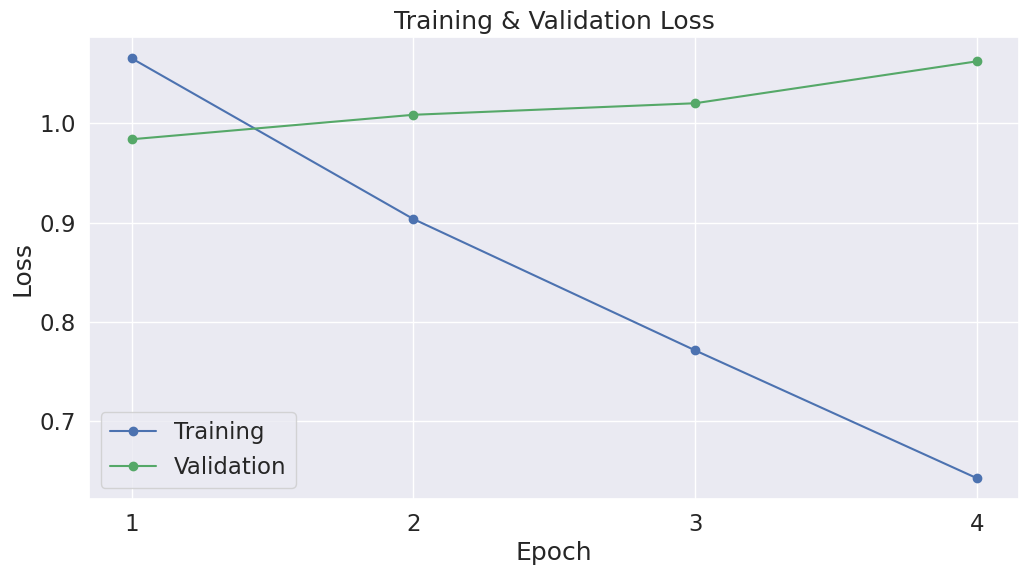

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50259, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

In [ ]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = '/content/drive/MyDrive/CS505_final_drive/final_project_gpt2_textgen_class1_epoch4'
output_dir1 = '/content/drive/MyDrive/CS505_final_drive/final_project_gpt2_tokenizer_class1_epoch4'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir1)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to /content/drive/MyDrive/CS505_final_drive/final_project_gpt2_textgen_class1_epoch4


('/content/drive/MyDrive/CS505_final_drive/final_project_gpt2_tokenizer_class1_epoch4/tokenizer_config.json',
 '/content/drive/MyDrive/CS505_final_drive/final_project_gpt2_tokenizer_class1_epoch4/special_tokens_map.json',
 '/content/drive/MyDrive/CS505_final_drive/final_project_gpt2_tokenizer_class1_epoch4/vocab.json',
 '/content/drive/MyDrive/CS505_final_drive/final_project_gpt2_tokenizer_class1_epoch4/merges.txt',
 '/content/drive/MyDrive/CS505_final_drive/final_project_gpt2_tokenizer_class1_epoch4/added_tokens.json')

In [ ]:
import random

print("Here are example of ten sentences from the original text:")
for x in range(10):
  print(f"{x}: {docs[random.randint(0,len(docs))]}")


Here are example of ten sentences from the original text:
0: Quite possibly the worst movie I have ever seen. I cannot believe this movie got made, with decent actors no less. Don't waste your time watching this movie, unless you enjoy senseless, annoying, and incredibly moronic writing. Movies produced using the works of Stephen King are typically quite awful. The only exceptions include movies that are based on short stories and movies that he himself did not have much to do with. This probably has something to do with the fact that he churns out mindless works one after another, much to the delight of his lowest common denominator audience. Save yourself the time and watch Magnolia.
1: Could not get interested in this replacement for two really good series I managed to watch a little over half of the series pilot during it's first airing on syfy channel. Later, I gave it another try during a repeat airing and got to the end. I'm not able to say that this encouraged me to watch furth

In [ ]:
model.eval()

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated,
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,
                                top_k=50,
                                max_length = 300,
                                top_p=0.95,
                                num_return_sequences=10
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257]], device='cuda:0')
0: Dreadful This movie is an insult to the intelligence of the viewers. The plot is stupid and makes no sense. The cast and the acting are as atrocious as they come. The storyline is mind-numbingly boring. The characters are too unbelievable. The script is preposterous. Even the special effects were lame. This movie is about as interesting as a bad box-office hit.


1: A mess The DVD offers  movie versions of the following movie. All  will be available on DVD with the standard English release.The problem I had with the supplier is not the seller, but the supplier's lack of service on the product when it comes to DVDs. I could not be bothered with this oversold DVD, as my order was excellent.


2: Why is it called quot;Stamp Your DVDquot; This movie is not really a film. It is a collection of clips from the  movies of the same name. It's hard to tell whether one is a bad film or a great movie.The title of the film is quot;Stamp Your DVDquot;, it has a 